In [1]:
# from openai import OpenAI
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import os
import glob 
from collections import defaultdict
import datetime
import time
import re
import numpy as np

# Annotation 

In [2]:
with open('/cluster/home/hlee37/git/gutenberg/openai_token.txt', 'r') as file:
    oa_api_key = file.read()

In [3]:
os.environ["OPENAI_API_KEY"] = oa_api_key
OpenAI.api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI()

In [4]:
def label_sentences_with_gpt(sentences, model="gpt-4.1-mini", batch_size=5, sleep_time=10):
  labeled = []
  for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    batch_str = "\n".join([f"{i + j + 1}. {s}" for j, s in enumerate(batch)])

    instructions = [{
            "role": "developer", "content": developer_prompt
        },
        {
            "role": "user", "content": f"Sentences:\n{batch_str}"
        }]
    try:
        response = client.responses.create(
          model=model,
          input=instructions,
        )

        output  = response.output_text
        labeled.append((batch, output))


    except Exception as e:
      print(f"error at batch {i}: {e}")
      continue

    print(f"Finished batch {i//batch_size + 1}")
    time.sleep(sleep_time)

  return labeled

In [5]:
folder_path = '/cluster/home/hlee37/git/gutenberg/phase2/final' # Replace with your actual folder path
labled_files = glob.glob(os.path.join(folder_path, "*.csv"))

all_dataframes = []
for file in labled_files:
    try:
        df = pd.read_csv(file)
        all_dataframes.append(df)
    except Exception as e:
        print(f"{e} exception at {file}")
        
combined_df = pd.concat(all_dataframes, ignore_index=True)
print("\nCombined DataFrame:")
print(combined_df.head())

No columns to parse from file exception at /cluster/home/hlee37/git/gutenberg/phase2/final/15_Major Warburton.csv
No columns to parse from file exception at /cluster/home/hlee37/git/gutenberg/phase2/final/28_Surveyor General Lewis.csv
No columns to parse from file exception at /cluster/home/hlee37/git/gutenberg/phase2/final/30_Winnecke.csv
No columns to parse from file exception at /cluster/home/hlee37/git/gutenberg/phase2/final/33_F. Hann.csv

Combined DataFrame:
                                            sentence  predicted_class
0  Here our dogs ran a native dog, but did not ki...                1
1  Wednesday, the25th August.-The two absentees d...                1
2  Next morning, however, just when we were looki...                1
3  They had continued down the creek without asce...                1
4  They now returned and camped on Monday night a...                1


In [6]:
combined_df.shape

(636992, 2)

In [7]:
sentences = combined_df['sentence'].to_list()

In [8]:
sentences[:10]

['Here our dogs ran a native dog, but did not kill him.',
 'Wednesday, the25th August.-The two absentees did not come up to the camp on Sunday evening nor during the forenoon on Monday; I consequently supposed that a serious accident had happened either to Mr Bunce or to Wommai, and resolved to return to the creek we had left, to ascertain in what direction they had gone.',
 'Next morning, however, just when we were looking out for our horses, they arrived.',
 "They had continued down the creek without ascertaining the direction of our tracks; they had come to the junction of our creek with a very large one; had found three fresh horse-tracks, and supposing them our's had followed them until late at night; they had crossed the large creek, to which we had come on Sunday; next day they had still continued and had considered that the mule-tracks were wanting, but foolishly supposed that the natives had rushed us.",
 'They now returned and camped on Monday night again at the little creek 

In [9]:
np.random.seed(50)

mask_size = 10000
mask = np.full(len(sentences), False)
mask[:mask_size] = True

np.random.shuffle(mask)

sample_sentences = [s for s, keep in zip(sentences, mask) if keep]
print(f"✅ Extracted {len(sample_sentences)} sentences from {len(sentences)}")

✅ Extracted 10000 sentences from 636992


In [ ]:
# sampling (if required)

# np.random.seed(50)

# mask_size = 5000
# mask = np.full(len(lable_sentences), False)
# mask[:mask_size] = True

# np.random.shuffle(mask)

# sample_sentences = [s for s, keep in zip(lable_sentences, mask) if keep]
# print(f"✅ Extracted {len(sample_sentences)} sentences from book3")

In [10]:
developer_prompt = """
You are a helpful research assistant labeling historical sentences from explorer diaries. Your task is to assign one of three sentiment labels to each sentence that was previously identified as describing a relationship or interaction between **Europeans** (e.g., settlers, colonists, explorers) and **Australian Aboriginal people** (e.g., Indigenous people, natives, blackfellows, tribes).

### 🔍 Label each sentence using one of:
- **positive**: the interaction is friendly, cooperative, compassionate, or shows mutual respect.
- **negative**: the interaction is hostile, fearful, violent, coercive, dismissive, or emotionally painful.
- **na**: the sentence was incorrectly marked as a relationship. It **does not actually describe an interaction** between the two groups.

⚠️ IMPORTANT:
- Focus on **emotionally meaningful interactions** — these are most useful for sentiment analysis.
- Label only what the sentence *clearly* expresses. Do not infer emotions that aren't stated or strongly implied.
- "na" should be used for sentences that mention Aboriginal people or Europeans but **lack any interaction or shared event**.

---

### ✅ Examples

Sentence: "I gave them what Fish we had, some fish Hooks, Twine and a Tomahawk, they appeared glad to get from us."
Label: positive  
Reason: Friendly and generous exchange; clear mutual goodwill.

Sentence: "They did not see us until we surprised them: there were only two Women and four Children, the poor Creatures trembled and fell down with fright."
Label: negative  
Reason: The Aboriginal people responded with visible fear — an emotionally intense encounter.

Sentence: "We have not yet seen any Natives but can see their late Tracks."
Label: na  
Reason: No actual encounter or interaction.

Sentence: "We met some natives on the plain and continued on our way."
Label: na  
Reason: Too vague to assess sentiment or qualify as a meaningful interaction.

Sentence: "After giving them some bread and water, they smiled and sat with us by the fire."
Label: positive  
Reason: A warm, friendly interaction with emotional and physical closeness.

Sentence: "They ran off upon seeing us, and would not return even when we called."
Label: negative  
Reason: Suggests fear or distrust; emotionally charged avoidance.

---

Now, label the following sentences. Use this format:

Sentence No.: <number>  
Sentence: "<exact sentence>"  
Label: <positive/negative/na>
"""

In [11]:
def parse_gpt_response(raw_text):
    entries = []
    pattern = re.compile(
        r"Sentence No\.\s*:\s*(\d+)\s*"
        r"Sentence\s*:\s*\"(.*?)\"\s*"
        r"Label\s*:\s*(positive|negative|na)",
        re.DOTALL
    )

    for match in pattern.finditer(raw_text):
        sentence_no = int(match.group(1))
        sentence = match.group(2).strip()
        label = match.group(3).strip()
        entries.append({
            "sentence_no": sentence_no,
            "sentence": sentence,
            "label": label
        })

    return entries

In [15]:
batch_size = 1000
checkpoint = None

try:
    with open("checkpoint.txt", 'r') as f:
        checkpoint = int(f.read())
        print(f"🔁 Resuming from checkpoint {checkpoint}")
except Exception as e:
    print(f"⚠️ No checkpoint found or error reading it: {e}")
    checkpoint = 0

for run in range(1):  # Change to 5 for 5-run voting
    print(f"🚀 Run {run}")
    
    for start in range(checkpoint, len(sentences), batch_size):
        now = datetime.datetime.now()
        batch_num = start // batch_size
        print(f"🏁 Starting batch {batch_num} at {now}")
        
        df = pd.DataFrame()
        sentence_text_map = {}
        label_runs = defaultdict(dict)

        try:
            results = label_sentences_with_gpt(
                sentences[start: start+batch_size], 
                model="gpt-4.1-mini", 
                batch_size=10, 
                sleep_time=2
            )
        except Exception as e:
            print(f"❌ GPT labeling failed for batch {batch_num}: {e}")
            continue
                    
        for _, output in results:
            parsed = parse_gpt_response(output)
            for row in parsed:
                sn = row["sentence_no"]
                sentence_text_map[sn] = row["sentence"]
                label_runs[sn][f"label_run_{run}"] = row["label"]
    
        rows = []
        for sn, labels in label_runs.items():
            row = {"sentence_no": sn, "sentence": sentence_text_map[sn]}
            row.update(labels)
            rows.append(row)
        
        df = pd.DataFrame(rows).sort_values(by="sentence_no").reset_index(drop=True)      
        
        output_dir = "/cluster/home/hlee37/git/gutenberg/phase3/result"
        output_filename = f"sentiment_annotation_gpt{batch_num}.csv"
        output_filepath = os.path.join(output_dir, output_filename)
        
        os.makedirs(output_dir, exist_ok=True)
        df.to_csv(output_filepath, index=False)
        
        # Save next start index
        next_checkpoint = start + batch_size
        with open("checkpoint.txt", 'w') as f:
            f.write(str(next_checkpoint))
        
        print(f"✅ Time: {datetime.datetime.now() - now}, checkpoint saved: {next_checkpoint}, batch: {batch_num}")


🔁 Resuming from checkpoint 4000
🚀 Run 0
🏁 Starting batch 4 at 2025-06-12 18:13:42.986123
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished batch 38
Finished batch 39
Finished batch 40
Finished batch 41
Finished batch 42
Finished batch 43
Finished batch 44
Finished batch 45
Finished batch 46
Finished batch 47
Finished batch 48
Finished batch 49
Finished batch 50
Finished batch 51
Fi

KeyboardInterrupt: 

# Import Files

In [2]:
folder_path = '/cluster/home/hlee37/git/gutenberg/phase3/result' # Replace with your actual folder path
labled_files = glob.glob(os.path.join(folder_path, "*.csv"))

all_dataframes = []
for file in labled_files:
    try:
        df = pd.read_csv(file)
        all_dataframes.append(df)
    except Exception as e:
        print(f"{e} exception at {file}")
        
combined_df = pd.concat(all_dataframes, ignore_index=True)
print("\nCombined DataFrame:")
print(combined_df.head())


Combined DataFrame:
   sentence_no                                           sentence label_run_0
0            1  Here our dogs ran a native dog, but did not ki...    negative
1            2  Wednesday, the25th August.-The two absentees d...          na
2            3  Next morning, however, just when we were looki...          na
3            4  They had continued down the creek without asce...          na
4            5  They now returned and camped on Monday night a...          na


In [3]:
combined_df[combined_df.duplicated()]

,sentence_no,sentence,label_run_0
5352,364,The two Somerset blacks evinced a great deal o...,na
5353,365,"Two of the black-boys were sent after them, an...",na
5355,367,"In a late letter from Cape York, Mr. Frank Jar...",na
5357,369,From this is would appear that they closely wa...,negative
5358,370,"The utter faithlessness, treachery, and savage...",negative
...,...,...,...
13767,782,I should like much to send one or two of the C...,na
13768,783,I believe that the reports which they would br...,positive
13769,784,"Next, the determined hostility of the natives,...",negative
13770,785,"They are on good terms with the natives, and t...",positive


In [4]:
combined_df.shape

(13986, 3)

In [5]:
final_df = combined_df[~combined_df.duplicated()]

In [6]:
final_df.groupby(['label_run_0'])['sentence'].count()

label_run_0
na          4449
negative    5640
positive    3165
Name: sentence, dtype: int64

# Preprocess

In [7]:
pd.set_option('max_colwidth', None)

In [8]:
final_df = final_df[final_df['label_run_0'] != 'na']

In [9]:
final_df

,sentence_no,sentence,label_run_0
0,1,"Here our dogs ran a native dog, but did not kill him.",negative
5,6,"Next morning they had come on our returning tracks and had followed them to the camp; they had seen a great number of natives, and had spoken with some of them; they had seen the little gin with the white patch on the neck, who passed our camp in going up to the Bunya Bunya.",positive
7,8,"We were encamped for a short time, and the fat cake not quite ready, when two natives walked boldly up after having cooeed and received our cooee in return.",positive
8,9,"I gave each of them three brass buttons, to show our friendly intentions, and gave them to understand that we were to sleep one night and then continue to the westward.",positive
9,10,"We parted good friends, thought Mr. Bunce told me that he heard them talking near our waterhole-they came perhaps there to fetch water.",positive
...,...,...,...
13980,995,"For a long time previous, the natives who visited the Settlement had been made to understand that Mr. Jardine expected his sons with horses and cattle, and had been familiarized with their names, ""Franco"" ""Alico"" as also with others such as ""Somerset,"" ""Cape York,"" ""Salamander,"" and ""Toby,"" (Mr. Jardine's well-known retreiver) the intention being that these should act as pass words when they met the party, a wise precaution, which, as it has been seen, probably prevented a collision.",positive
13981,996,"Thus, on nearing the Settlement the blacks set up the shouts that had alarmed him, screaming out his name Joko, Franco, Alicko, and such was the eagerness of each to prove that he (smiting himself on the breast) was ""Kotaiga"" or friend, pointing at the same time to the Brothers, as a witness of their truth, that it was with some difficulty that the Father could reach his sons to greet and welcome them.",positive
13982,997,"During the hubbub caused by the tumultuous demonstrativeness of the natives, an amusing episode occurred, which is worthy of record.",positive
13983,998,"The two Somerset blacks evinced a great deal of surprise at sight of the cattle, and expressed it by chirping and making various curious noises with their tongues and mouths.",positive


In [10]:
final_df.shape

(8805, 3)

In [11]:
final_df['sentence'].str.len().median()

222.0

In [12]:
final_df[final_df['sentence'].str.len() < 200].shape[0]

3561

# Train BERT

In [14]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
from datasets import Dataset
from torch.nn import CrossEntropyLoss
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

In [15]:
final_df = final_df[['sentence', 'label_run_0']]

In [16]:
final_df.columns = ['sentence', 'label']
df_final = final_df

In [17]:
df_final.iloc[:,1]

0        negative
5        positive
7        positive
8        positive
9        positive
           ...   
13980    positive
13981    positive
13982    positive
13983    positive
13985    positive
Name: label, Length: 8805, dtype: object

In [18]:
df_final['label'] = df_final.iloc[:,1:].applymap(lambda x:1 if x == 'positive' else 0)

/tmp/ipykernel_183160/2998654369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['label'] = df_final.iloc[:,1:].applymap(lambda x:1 if x == 'positive' else 0)


In [19]:
# STEP 1: Load and encode labels

class_counts = df_final["label"].value_counts().to_dict()
print("Class distribution:", class_counts)

Class distribution: {0: 5640, 1: 3165}


In [20]:
# STEP 2: 3-way Split → train (70%), val (15%), test (15%)
df_train, df_temp = train_test_split(df_final, test_size=0.3, stratify=df_final["label"], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["label"], random_state=42)

print(f"Train size: {len(df_train)}, Val size: {len(df_val)}, Test size: {len(df_test)}")
print(f"Train ys {len(df_train[df_train['label'] == 1])}, Val ys {len(df_val[df_val['label'] == 1])}, Test ys {len(df_test[df_test['label'] == 1])}")

Train size: 6163, Val size: 1321, Test size: 1321
Train ys 2215, Val ys 475, Test ys 475


In [21]:
# STEP 3: Tokenization

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

true_max_length = max([len(s.split()) for s in df_train['sentence']]) 

if true_max_length > 512:
    print(f"max length exceed 512 at {true_max_length}")
    true_max_length = 512
    
print(f"For submission, max_length is :{true_max_length}")


def tokenize_function(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=true_max_length)


# Convert to HuggingFace datasets
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# train_ds.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
# val_ds.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
# test_ds.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

For submission, max_length is :198


Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1321/1321 [00:00<00:00, 1567.88 examples/s]


# Bert Model

In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# STEP 6: Training arguments

training_args = TrainingArguments(
    output_dir="./results",                 # Folder to save checkpoints and logs
    num_train_epochs=4,                     # Number of full passes through the training set
    per_device_train_batch_size=16,         # Batch size per GPU/CPU for training
    per_device_eval_batch_size=64,          # Batch size per GPU/CPU for evaluation (can be larger)
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir="./logs",                   # Directory for storing logs (TensorBoard, etc.)
    logging_steps=10,                       # Log metrics every 10 steps (if logging_strategy="steps")
    load_best_model_at_end=True,            # Restore the best model (lowest eval loss) at the end
    metric_for_best_model="precision",      # Metric to monitor for choosing the best model
    greater_is_better=True,
    save_total_limit=1,                     # Keep only the most recent checkpoint (saves disk space)
    report_to = "none",
    run_name = "bert_relationship_classifier_run_book1&2&3_precision"
)

In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Assumes model outputs logits

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1_macro': f1,
        'eval_precision': precision,  # renamed key
        'recall_macro': recall,
    }

In [26]:
# STEP 7: Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1 Macro,Recall Macro
1,0.072500,0.100608,0.964079,0.967449,0.964710,0.965354
2,0.025200,0.115989,0.960683,0.965935,0.963235,0.966018
3,0.008200,0.117563,0.963071,0.966692,0.963906,0.964763
4,0.023100,0.109303,0.961068,0.965178,0.962300,0.963581


TrainOutput(global_step=1544, training_loss=0.07039759127625839, metrics={'train_runtime': 175.4966, 'train_samples_per_second': 140.47, 'train_steps_per_second': 8.798, 'total_flos': 2508340468502880.0, 'train_loss': 0.07039759127625839, 'epoch': 4.0})

In [28]:
# STEP 9: Final Evaluation on Held-out Test Set
print("✅ Final Test Evaluation:")
eval_results = trainer.evaluate(eval_dataset=test_ds)
print(eval_results)

✅ Final Test Evaluation:


{'eval_precision': 0.9673375503162738, 'eval_loss': 0.09861911088228226, 'eval_accuracy': 0.9689629068887207, 'eval_f1_macro': 0.9662267368808324, 'eval_recall_macro': 0.96515117581187, 'eval_runtime': 2.9255, 'eval_samples_per_second': 451.545, 'eval_steps_per_second': 7.178, 'epoch': 4.0}


In [29]:
pred_output = trainer.predict(test_ds)

pred_logits = pred_output.predictions
true_labels = pred_output.label_ids
pred_probs = torch.softmax(torch.tensor(pred_logits), dim=1).numpy()
pred_labels = pred_probs.argmax(axis=1)

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print(classification_report(true_labels, pred_labels, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.97      0.98      0.98       846
    positive       0.96      0.95      0.96       475

    accuracy                           0.97      1321
   macro avg       0.97      0.97      0.97      1321
weighted avg       0.97      0.97      0.97      1321



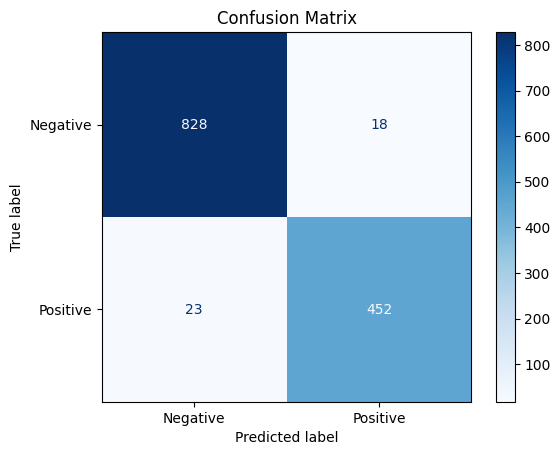

In [34]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

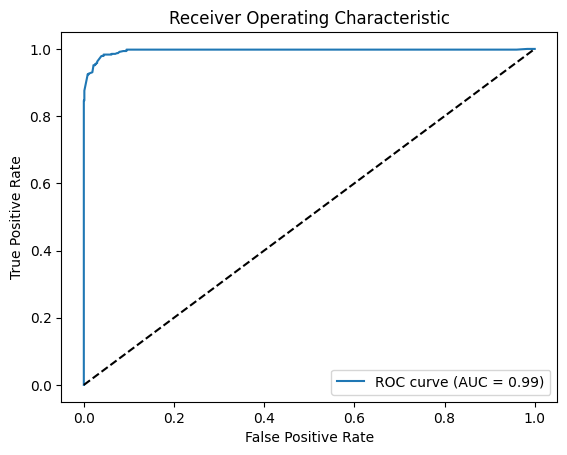

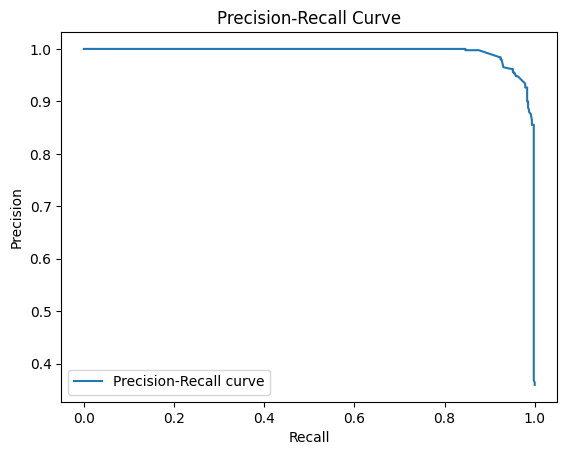

In [35]:
df_test = df_test.reset_index(drop=True)

# Add predictions to test set
df_test["true_label"] = true_labels
df_test["pred_label"] = pred_labels
df_test["prob_rel"] = pred_probs[:, 1]  # class 1 = RELATIONSHIP

# ROC
fpr, tpr, _ = roc_curve(true_labels, pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(true_labels, pred_probs[:, 1])

plt.figure()
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [36]:
model.save_pretrained("./sentiment-bert-first-model")
tokenizer.save_pretrained("./sentiment-bert-first-model")

('./sentiment-bert-first-model/tokenizer_config.json',
 './sentiment-bert-first-model/special_tokens_map.json',
 './sentiment-bert-first-model/vocab.txt',
 './sentiment-bert-first-model/added_tokens.json')

In [23]:
# Already set up earlier with CustomTrainer and `compute_metrics`
# Define a model_init function
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


def model_init():
    return BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "eval_accuracy": accuracy_score(labels, preds),
        "eval_precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "eval_recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "eval_f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
    }

# Define the hyperparameter space function that uses the trial object
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        # "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 6),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3)
    }

def compute_objective(metrics):
    return metrics["eval_f1_macro"] 

training_args = TrainingArguments(
    output_dir="./results",                 # Folder to save checkpoints and logs
    num_train_epochs=4,                     # Number of full passes through the training set
    per_device_train_batch_size=16,         # Batch size per GPU/CPU for training
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir=None,                   # Directory for storing logs (TensorBoard, etc.)
    logging_steps=10,                       # Log metrics every 10 steps (if logging_strategy="steps")
    load_best_model_at_end=True,            # Restore the best model (lowest eval loss) at the end
    metric_for_best_model="eval_f1_macro",      # Metric to monitor for choosing the best model
    save_total_limit =1, 
    greater_is_better=True, 
    report_to = "none"
)

In [25]:
trainer = Trainer(
    model_init=model_init,                     # <—— pass it here
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)


best_run = trainer.hyperparameter_search(
    hp_space=optuna_hp_space,
    compute_objective=compute_objective,
    direction="maximize",
    n_trials=10,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-16 13:36:03,076] A new study created in memory with name: no-name-a650934c-bb18-424a-b900-3201056c878f
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.066200,0.096094,0.961393,0.962225,0.953702,0.957707
2,0.048500,0.093254,0.969720,0.964913,0.969897,0.967305
3,0.009100,0.094638,0.968963,0.964616,0.968382,0.966443
4,0.019700,0.092681,0.967449,0.963704,0.965816,0.964742


[I 2025-06-16 13:40:26,584] Trial 0 finished with value: 0.9647423941008699 and parameters: {'learning_rate': 1.0724049175708623e-05, 'weight_decay': 0.1523630956894824}. Best is trial 0 with value: 0.9647423941008699.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.073600,0.090853,0.966692,0.963450,0.964301,0.963873
2,0.037300,0.103583,0.965178,0.959092,0.966351,0.962500
3,0.007100,0.098245,0.968206,0.965091,0.965945,0.965515
4,0.026700,0.098563,0.968206,0.965091,0.965945,0.965515


[I 2025-06-16 13:44:50,425] Trial 1 finished with value: 0.9655151409676296 and parameters: {'learning_rate': 2.261661144028213e-05, 'weight_decay': 0.09626749578591533}. Best is trial 1 with value: 0.9655151409676296.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.091900,0.102816,0.959879,0.962582,0.950212,0.955873
2,0.041600,0.098214,0.965935,0.960362,0.966480,0.963267
3,0.007500,0.103171,0.966692,0.961333,0.967071,0.964068
4,0.023900,0.095908,0.968963,0.964269,0.968844,0.966473


[I 2025-06-16 13:49:14,155] Trial 2 finished with value: 0.9664729321590821 and parameters: {'learning_rate': 2.8610106381072803e-05, 'weight_decay': 0.15669653052137436}. Best is trial 2 with value: 0.9664729321590821.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.070300,0.094962,0.968206,0.963626,0.967791,0.965640
2,0.041700,0.118770,0.962907,0.956233,0.964578,0.960106
3,0.007800,0.095642,0.968963,0.964973,0.967921,0.966413
4,0.026700,0.093547,0.968963,0.964616,0.968382,0.966443


[I 2025-06-16 13:53:37,431] Trial 3 finished with value: 0.9664429363871184 and parameters: {'learning_rate': 1.9257922496933035e-05, 'weight_decay': 0.08168687530643723}. Best is trial 2 with value: 0.9664729321590821.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.069700,0.095791,0.964421,0.958135,0.965760,0.961702
2,0.054100,0.108256,0.967449,0.962985,0.966739,0.964806
3,0.007400,0.119355,0.965935,0.961706,0.964634,0.963136
4,0.019900,0.115655,0.965935,0.961014,0.965557,0.963202


[I 2025-06-16 13:58:00,738] Trial 4 finished with value: 0.963201998711188 and parameters: {'learning_rate': 4.692960442630243e-05, 'weight_decay': 0.011335295980089921}. Best is trial 2 with value: 0.9664729321590821.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.082700,0.098726,0.966692,0.963840,0.963840,0.963840
2,0.053100,0.103180,0.966692,0.961016,0.967533,0.964099
3,0.009400,0.093382,0.965935,0.962440,0.963710,0.963069


[I 2025-06-16 14:01:33,079] Trial 5 pruned. 
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.052900,0.092593,0.965935,0.960683,0.966018,0.963235
2,0.034600,0.112074,0.965935,0.960683,0.966018,0.963235


[I 2025-06-16 14:03:58,448] Trial 6 pruned. 
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.075700,0.099753,0.961393,0.962719,0.953240,0.957665


[I 2025-06-16 14:05:17,482] Trial 7 pruned. 
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.080100,0.080791,0.968206,0.963626,0.967791,0.965640
2,0.030700,0.136216,0.964421,0.958135,0.965760,0.961702
3,0.007500,0.092593,0.965935,0.960683,0.966018,0.963235


[W 2025-06-16 14:08:50,271] Trial 8 failed with parameters: {'learning_rate': 4.641901189244264e-05, 'weight_decay': 0.2839856342153951} because of the following error: OSError(122, 'Disk quota exceeded').
Traceback (most recent call last):
  File "/cluster/home/hlee37/condaenv/torch_env/lib/python3.8/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/cluster/home/hlee37/condaenv/torch_env/lib/python3.8/site-packages/transformers/integrations/integration_utils.py", line 248, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/cluster/home/hlee37/condaenv/torch_env/lib/python3.8/site-packages/transformers/trainer.py", line 2123, in train
    return inner_training_loop(
  File "/cluster/home/hlee37/condaenv/torch_env/lib/python3.8/site-packages/transformers/trainer.py", line 2573, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_

OSError: [Errno 122] Disk quota exceeded: './results/run-8/checkpoint-1158'

In [26]:
# Set metric
metric_to_use = "eval_f1_macro"

# Define base path for all runs
base_path = "./results"

best_score = -1
best_run = None

# Loop over run-* folders
for run_dir in sorted(os.listdir(base_path)):
    run_path = os.path.join(base_path, run_dir)
    if os.path.isdir(run_path) and re.match(r"run-\d+", run_dir):
        try:
            # Find latest checkpoint-* folder inside run_dir
            checkpoints = [f for f in os.listdir(run_path) if f.startswith("checkpoint-")]
            if not checkpoints:
                continue
            latest_ckpt = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))[-1]
            model_path = os.path.join(run_path, latest_ckpt)

            # Load model and evaluate
            model = BertForSequenceClassification.from_pretrained(model_path)
            trainer.model = model.to(trainer.args.device)
            metrics = trainer.evaluate(eval_dataset=val_ds)

            score = metrics.get(metric_to_use)
            print(f"{run_dir}/{latest_ckpt} → {metric_to_use}: {score:.4f}")

            if score is not None and score > best_score:
                best_score = score
                best_run = model_path

        except Exception as e:
            print(f"⚠️ Skipping {run_dir}: {e}")

print(f"\n🏆 Best checkpoint: {best_run} with {metric_to_use}: {best_score:.4f}")

run-0/checkpoint-772 → eval_f1_macro: 0.9673
run-1/checkpoint-1158 → eval_f1_macro: 0.9655
run-2/checkpoint-1544 → eval_f1_macro: 0.9665
run-3/checkpoint-1544 → eval_f1_macro: 0.9664
run-4/checkpoint-772 → eval_f1_macro: 0.9648
run-5/checkpoint-772 → eval_f1_macro: 0.9641
run-6/checkpoint-386 → eval_f1_macro: 0.9632

🏆 Best checkpoint: ./results/run-0/checkpoint-772 with eval_f1_macro: 0.9673


In [28]:
best_params = {
    "learning_rate": 0.000010724049175708623,
    "weight_decay": 0.1523630956894824
}

In [30]:
# best_params = best_run.hyperparameters

training_args = TrainingArguments(
    output_dir="./best-results",                             # you can change this
    num_train_epochs=4,
    per_device_train_batch_size= 16,
    eval_strategy=IntervalStrategy.EPOCH,            # Run evaluation after each training epoch
    save_strategy=IntervalStrategy.EPOCH,                  # Save model checkpoint after each epoch
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=False,
    metric_for_best_model="eval_f1_macro",
    weight_decay=best_params["weight_decay"],
    learning_rate=best_params["learning_rate"],
    save_total_limit=1, 
    report_to="none"                                         # turn off wandb if needed
)

model = BertForSequenceClassification.from_pretrained(
    "./results/run-0/checkpoint-772"
)

trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.037200,0.158352,0.956094,0.959701,0.944948,0.951588
2,0.035300,0.102127,0.965935,0.962440,0.963710,0.963069
3,0.008700,0.106473,0.966692,0.963450,0.964301,0.963873
4,0.017800,0.108748,0.965935,0.962823,0.963249,0.963035


TrainOutput(global_step=1544, training_loss=0.04532681409284048, metrics={'train_runtime': 261.9959, 'train_samples_per_second': 94.093, 'train_steps_per_second': 5.893, 'total_flos': 2508340468502880.0, 'train_loss': 0.04532681409284048, 'epoch': 4.0})

In [31]:
eval_results = trainer.evaluate(eval_dataset=test_ds)
print(eval_results)

{'eval_accuracy': 0.967448902346707, 'eval_precision_macro': 0.9652682118544249, 'eval_recall_macro': 0.9639691427149434, 'eval_f1_macro': 0.9646123607230409, 'eval_loss': 0.10811550915241241, 'eval_runtime': 4.0429, 'eval_samples_per_second': 326.748, 'eval_steps_per_second': 41.06, 'epoch': 4.0}


In [32]:
# Save final model
trainer.save_model("./best-sentiment-bert")
tokenizer.save_pretrained("./best-sentiment-bert")

('./best-sentiment-bert/tokenizer_config.json',
 './best-sentiment-bert/special_tokens_map.json',
 './best-sentiment-bert/vocab.txt',
 './best-sentiment-bert/added_tokens.json')